In [1]:
!pip install tensorflow_datasets

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
  
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

In [3]:
def map_image_with_noise (image , label):
    noise_factor=0.5
    image = tf.cast(image , dtype =tf.float32 )
    image = image /255.0
    factor = noise_factor * tf.random.normal(shape = image.shape)
    image_noisy = image + factor
    image_noisy = tf.clip_by_value(image_noisy , 0.0 , 1.0)
    return image_noisy , image
    

In [4]:
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024

train_dataset = tfds.load('fashion_mnist', as_supervised=True, split="train")
train_dataset = train_dataset.map(map_image_with_noise)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_dataset = tfds.load('fashion_mnist', as_supervised=True, split="test")
test_dataset = test_dataset.map(map_image_with_noise)
test_dataset = test_dataset.batch(BATCH_SIZE).repeat()

In [5]:
def denoising_encoder(inputs):
    conv_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same")(inputs)
    max_pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_1)  # Downsample to (14, 14)
    
    conv_2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same")(max_pool_1)
    max_pool_2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_2)  # Downsample to (7, 7)
    
    return max_pool_2


def decoder(inputs):
    conv_1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same")(inputs)
    up_sample_1 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv_1)  # Upsample to (14, 14)
    
    conv_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same")(up_sample_1)
    up_sample_2 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv_2)  # Upsample to (28, 28)
    
    conv_3 = tf.keras.layers.Conv2D(filters=1, kernel_size=(3, 3), activation="sigmoid", padding="same")(up_sample_2)
    return conv_3


   


In [6]:
def build_autoencoder():
    inputs = tf.keras.layers.Input(shape=(28, 28, 1))
    encoded = denoising_encoder(inputs)
    decoded = decoder(encoded)
    autoencoder = tf.keras.Model(inputs, decoded)
    return autoencoder

In [7]:
autoencoder = build_autoencoder()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [8]:
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 28, 28, 1)           │             577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 296,449 (1.13 MB)

 Trainable params: 296,449 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = autoencoder.fit(train_dataset,
                          epochs=10,
                          steps_per_epoch=60000 // BATCH_SIZE,
                          validation_data=test_dataset,
                          validation_steps=10000 // BATCH_SIZE)

Epoch 1/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 222s 422ms/step - loss: 0.3538 - val_loss: 0.3024
Epoch 2/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 134s 287ms/step - loss: 0.2985 - val_loss: 0.2984
Epoch 3/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 140s 299ms/step - loss: 0.2941 - val_loss: 0.2942
Epoch 4/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 166s 354ms/step - loss: 0.2910 - val_loss: 0.2918
Epoch 5/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 161s 344ms/step - loss: 0.2894 - val_loss: 0.2906
Epoch 6/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 378s 809ms/step - loss: 0.2880 - val_loss: 0.2900
Epoch 7/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 332s 710ms/step - loss: 0.2873 - val_loss: 0.2890
Epoch 8/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 354s 756ms/step - loss: 0.2868 - val_loss: 0.2889
Epoch 9/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 353s 754ms/step - loss: 0.2862 - val_loss: 0.2879
Epoch 10/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 344s 734ms/step - loss: 0.2857 - val_loss: 0.2877


In [11]:
def display_noisy_and_denoised_images(autoencoder, dataset):
    for noisy_images, original_images in dataset.take(1):
        denoised_images = autoencoder.predict(noisy_images)
        plt.figure(figsize=(20, 4))
        for i in range(10):
            # Display original noisy images
            ax = plt.subplot(2, 10, i + 1)
            plt.imshow(noisy_images[i].numpy().reshape(28, 28), cmap='gray')
            plt.title("Noisy")
            plt.axis("off")
            
            # Display denoised images
            ax = plt.subplot(2, 10, i + 11)
            plt.imshow(denoised_images[i].reshape(28, 28), cmap='gray')
            plt.title("Denoised")
            plt.axis("off")
        plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step


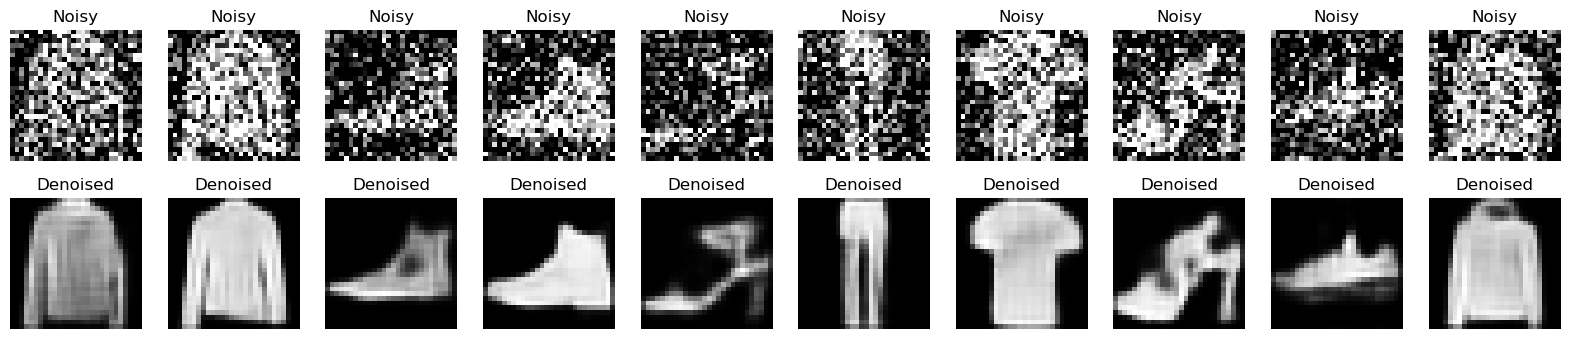

In [12]:
display_noisy_and_denoised_images(autoencoder, test_dataset)